In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from numpy.random import normal, uniform
import numpy as np
import pickle
import pandas as pd
import sys
from random import shuffle
sys.path.append("../../Preprocessing/")
#Going straight to the LM corpus to make sense of this
from copy import deepcopy
from language_model.ngram_language_model import KneserNeySmoothingModel
from collections import defaultdict
from extract_utils import lsdir

In [50]:
acoustic_features = 'label ~ pcm_RMSenergy_sma + rms_minus_one + rms_minus_two + rms_minus_three + rms_minus_four +\
pcm_LOGenergy_sma + pcm_loudness_sma + pcm_intensity_sma  +\
zscore + duration + intensity_mean + intensity_slope +\
F0final_sma + F0raw_sma + F0_mean + F0_slope'

#acoustic_features = 'label ~ time_in_sec + \
#pcm_RMSenergy_sma + rms_minus_one + rms_minus_two + rms_minus_three + rms_minus_four +\
#pcm_LOGenergy_sma + pcm_loudness_sma + pcm_intensity_sma  +\
#intensity_mean + intensity_slope'

 ######################################################
lm_features = 'label ~ wml + wml_trigram + entropy'

def plot_hist(numbers_1, numbers_2, label_1, label_2, title,num_bins=10, x_range=[],y_range=[], feature="WML"):
    #plt.legend(loc="upper left", bbox_to_anchor=[0, 1],
    #       ncol=2, shadow=True, title="Legend", fancybox=True)
    plt.xlim(x_range)
    plt.ylim(y_range)
    plt.hist(numbers_1, bins=num_bins, histtype='stepfilled', normed=True, color='b', label=label_1)
    plt.hist(numbers_2, bins=num_bins, histtype='stepfilled', normed=True, color='r', alpha=0.5, label=label_2)
    plt.title(title)
    plt.xlabel(feature)
    plt.ylabel("Freq.")
    plt.legend(loc="upper left", bbox_to_anchor=[0, 1],
           ncol=2, shadow=True, fancybox=True)
    plt.show()

In [5]:
corpusfile = open("../../Preprocessing/utterances_for_LM.txt")
#clean and put into folds for each speaker, testing on the one left out
folds = defaultdict(str)
for line in corpusfile:
    line = line.strip("\n")
    if line == "": continue
    line = line.replace(":","").replace("?","").replace("!","").replace(".","").replace(",","")
    line = line.split()
    line = [w for w in line if not "<" in w]
    raw_words = line
    speaker= raw_words.pop(0)
    ep = raw_words.pop(0)
    words = []
    for w in raw_words:
        if w == "MTP": continue
        words.append(w.lower()) #w.lower()
    folds[speaker]+=" ".join(words) + "\n"
corpusfile.close()
#folds["2"]

In [22]:
def get_words_and_frame_positions_of_start_times(df,feature):
    words_idx = [] #a list of (word,end_time) tuples from df
    #need to check the values we're getting here from the dfs sanity check
    x = pd.Series(df.time_in_sec.astype(float))
    words = df[['words']]
    wml = df[[feature]]
    
    current_words = "<null>"
    for i in range(0,len(words)):
        my_words = str(words.iloc[[i]].words.values[0].encode("utf-8"))
        #word = word.replace(":","").replace("?","")
        word = my_words.split(";")[-1]
        if "<" in word: continue
        if word == "MTP": continue
        if not my_words == current_words:
            local_wml = float(wml.iloc[[i]].values[0])
            words_idx.append((word.lower(),local_wml,i))
            current_words = my_words
    return words_idx

In [ ]:
eppath = "../../../../eot_detection_data/Data/pickled_episodes/"
overall_final = []
overall_non_final = []

for t in range(2,8):
    target = str(t)
    if t >3: 
        heldout = str(t-1)
    else: 
        heldout = str(t+1)
    lmstring = ""
    print "target", target, "heldout", heldout
    for f in folds.keys():
        if f==target: 
            print "skipping fold",f
            continue
        lmstring+=folds[f]
    #trying 0.9 heldout version like Angelika's script
    incorpus = sorted(lmstring.split("\n"))
    #shuffle(incorpus) # shuffle
    heldout_split = int(len(incorpus)*0.9)
    print "training size", heldout_split
    corpus = "\n".join(incorpus[:heldout_split])
    hcorpus = "\n".join(incorpus[heldout_split:])
    file = open("test_jh_model.text","w")
    file.write(corpus+"\n\n HELDOUT \n" + hcorpus)
    file.close()

    lm = KneserNeySmoothingModel(order=3,
                                     discount=0.7,
                                     partial_words=True,
                                     train_corpus=corpus,
                                     heldout_corpus=hcorpus,
                                     second_corpus=None)


    final = []
    non_final = []
    
    for f in folds.keys():
        if not f ==  target:
            continue
        ep_paths = lsdir(eppath+'/r'+str(f)+'/','pkl')
        for raw_path in ep_paths:
        #for line in folds[f].split("\n"):
            #if not "100" in raw_path: continue
            path = eppath + '/r' + str(f) + '/' + raw_path
            #print path
            test_ep_df = pickle.load(open(path,'rb'))
            words_idx = get_words_and_frame_positions_of_start_times(test_ep_df, feature="wml_trigram")
        #for l in folds[f].split("\n"):
            #print l
            words = ["<s>"] * (lm.order-1) + [w for w,local_wml,i in words_idx] + ["<eot>"]
            wml_s = ["<s>"] * (lm.order-1) + [local_wml for w,local_wml,i in words_idx] + ["<eot>"]
            print wml_s
            #print words
            #if f == "6":
            #    print "words",words
            #raw_input()
            if line == "": continue
            #words = ["<s>"] * (lm.order-1) + line.split() + ["</s>"]
            print words
            for w in range(lm.order-1,len(words)-1):
                #print words[w]
                #if not words[w] in lm.unigrams:
                #    print "not in uni", words[w]
                if words[w] == 'mtp': continue #to get rid of false hope
                eot_ngram = words[ w-(lm.order-2) : w+1 ] + ["</s>"]
                eot_all = words[:w+1] + ["</s>"]
                #print eot_all
                #lwbi = lm.raw_ngram_prob(eot_ngram,lm.discount,lm.order)
                lwbi_wml = lm.logprob_weighted_by_inverse_unigram_logprob(eot_all)
                                                                         
                                                            
                #lwbi_h = lm.entropy(" ".join(words[lm.order-1:w+1]  + ["<eot>"] ),lm.order)
                #lwbi_log_weight = lm.logprob_weighted_by_sequence_length(eot_all)
                #lwbi_all = lm.logprob(" ".join(eot_all[(lm.order-1):]))
                #print eot_ngram, lwbi_wml
                lwbi = lwbi_wml
                test_wml = wml_s[w]
                lwbi = test_wml
                #if not lwbi == test_wml:
                #    print "NO WML!!!!!"
                #    print eot_ngram,lwbi,"am:",test_wml
                #else:
                #    print "ok",eot_ngram,lwbi,test_wml
                #lwbi = test_wml #to check values
                #print eot_ngram,lwbi
                if w < len(words)-2:
                #   print 'non final'
                    non_final.append(lwbi)
                    overall_non_final.append(lwbi)
                else:
                    print "final"
                    
                    final.append(lwbi)
                    overall_final.append(lwbi)
    print "AVERAGE &&&&&&&&&&&&&&&&&&&"
    print np.average(final), np.average(non_final)
    
    #plot_hist(final,non_final,'Final','Non-final','WML for word,<eot> for final and non-final words',num_bins=12)


target 2 heldout 3
skipping fold 2
training size 766
training corpus is a string
Training on standard data...
TOTAL WORDS TRAINED ON = 5225
using heldout corpus
training corpus is a string
Training on heldout data...
unknown words in heldout data 42
TOTAL WORDS TRAINED ON = 6020
6020 total words of training data
1-grams = 303
2-grams = 1503
3-grams = 2682
['<s>', '<s>', -0.6995213154888678, -0.6503085070560338, -0.5762911345394383, -1.1232301809494294, -1.1845962244455657, -0.6995213154888678, -0.02980786590383179, '<eot>']
['<s>', '<s>', 'es', 'ist', 'gelb', 'nur', 'ein', 'vertikaler', 'balken', '<eot>']
final
['<s>', '<s>', -0.6995213154888678, -0.6503085070560338, -1.117915778532808, -0.3131179937051522, '<eot>']
['<s>', '<s>', 'es', 'ist', 'unten', 'links', '<eot>']
final
['<s>', '<s>', -0.6995213154888678, -0.43730280937456817, -1.1232301809494294, -0.872498007974872, -0.21291184902681987, -1.1845962244455657, -0.6995213154888678, -0.43730280937456817, -1.2464603618988588, -0.5762

KeyboardInterrupt: 

-0.618738293081 0.475008270534 -1.0898497965 0.587025994961


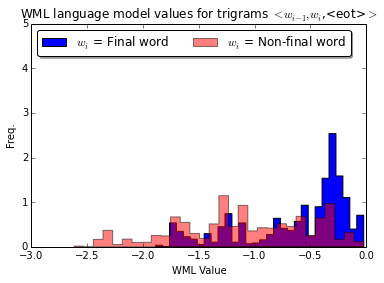

In [52]:
print np.average(overall_final), np.std(overall_final), np.average(overall_non_final), np.std(overall_non_final)
fig = plt.figure()
plot_title = 'WML language model values for trigrams $<w_{i-1},w_i$,<eot>$>$'
feature_name = "WML Value"
plot_hist(overall_final,overall_non_final,'$w_i$ = Final word',
          '$w_i$ = Non-final word',
          plot_title,
          num_bins=30,
          x_range=[-3,0],
          y_range=[0,5],
         feature=feature_name)
fig.savefig("../../../Paper/Interspeech/submission/WML_values.pdf")

0.845966989167 0.951973005378 0.0526938837345 1.08415686476


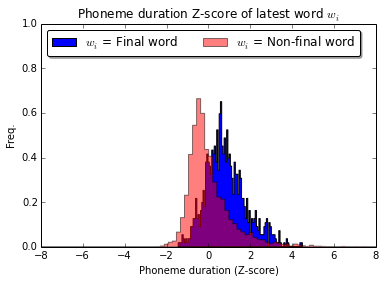

In [32]:
print np.average(overall_final), np.std(overall_final), np.average(overall_non_final), np.std(overall_non_final)
fig = plt.figure()
feature_name = "Phoneme duration (Z-score)"
plot_hist(overall_final,overall_non_final,'$w_i$ = Final word',
          '$w_i$ = Non-final word',
          'Phoneme duration Z-score of latest word $w_i$',
          num_bins=100,
          x_range=[-8,8],
          y_range=[0,1],
         feature=feature_name)
fig.savefig("../../../Paper/Interspeech/submission/Zscore_values_done.pdf")